<h1 align='center'>Aplicação de Processamento de Linguagem Natural <br>em comentários de um aplicativo de entregas disponível na Play Store</h1>

In [48]:
(HTML("""
<script>
code_show=true; function code_toggle() { 
   if (code_show){ $('div.input').hide(); 
   } else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle); 
</script>

<br>Clique <a href="javascript:code_toggle()">aqui</a> para mostrar o código.
"""))

In [ ]:
# Pacootes necessários para a análise
#!pip install gensim
#!pip install pyLDAvis

In [9]:
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import glob, os, sys

import gensim
from gensim import models,corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

%matplotlib inline
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'
pyLDAvis.enable_notebook()

<h3>Objetivo e Dados</h3>

<p>Este relatório desenvolve uma aplicação de processamento de linguagem natural, com o objetivo de extrair conhecimento sobre a percepção dos clientes sobre o serviço prestado por um aplicativo de entregas, a Shipp Delivery.</p>
<p>Para atingir este resultado, foi aplicado um algoritmo para modelagem de tópicos (Latent Dirichlet Allocation - LDA) nos <a href='https://play.google.com/store/apps/details?id=delivery.shipp.shippcliente&hl=pt_BR'>comentários do aplicativo disponíveis na Google Play Store</a> entre 2018 e 2019.</p>
<p>Foram coletados, em HTML bruto, aproximandamente 1100 comentários. Os dados, disponíveis no arquivo "comentarios.txt" foram tratados com o script "word_token.py", disponíveis na pasta "source".</p>
<p>A tabela abaixo mostra uma sumarização do que foi obtido para a análise proposta.</p>

In [34]:
df = pd.read_csv('source/tabela_comentario.csv', encoding='utf-16').dropna()
df[['nome', 'aval', 'data', 'lemma']]

,nome,aval,data,lemma
0,Carolina Scopel,5,14/11/2019,amo app nao conseguindo utiliza-lo deslogou na...
1,deborah Domingues,2,13/11/2019,transtorno atras transtorno unica vantagem shi...
2,Henrique Silva,3,10/12/2019,app bom porem nao consigo fazer pedidos cidade...
3,Vitor Bastos,2,23/10/2019,servico shipp bom app trava constantemente fic...
4,Túlio Soares Mariante,1,7/11/2019,primeira copra app loja basque avisado colocas...
...,...,...,...,...
1037,samuel xavier,5,29/4/2018,otimo app
1038,Paola da Costa,1,23/10/2019,nao gostei
1039,nao Sei,5,16/11/2019,app maravilhoso
1040,Moto Filmador,5,16/5/2018,bom


<h3>Modelo de Tópicos Probabiliscos</h3>

<p> Para tentar sumarizar em os mais de 1000 comentários coletados, o modelo escolhido foi o LDA. De forma simplificada, como a figura abaixo mostra, o objetivo da aplicação do modelo é gerar tópicos com base na distribuição de termos nos documentos de texto (no caso específico, comentários).</p>
    
<p>Para uma explicação mais detalhada, ver <a href='http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf'>Blei, Ng e Jordan (2003)</a> e <a href='http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf'>Blei (2012) </a></p>

<img src='source/lda_intuition.png' width=800px>

In [12]:
# Criando Dicionario
coments = [d.split() for d in df['lemma']]
id2word = corpora.Dictionary(coments)

# criando vetores das palavras
vec_coment = [id2word.doc2bow(coment) for coment in coments]

In [13]:
def cv(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
model_list, coherence_values = cv(dictionary=id2word, corpus=vec_coment, texts=coments, start=1, limit=20, step=1)

<p>Um indicador utilizado para escolher a quantidade de tópicos é o Coherence Score. Em linhas gerais, o indicador mensura o grau de semelhança semantica entre as palavras mais relevantes do tópico. Deste modo, quanto maior o score, maior a intepretação dos tópicos (<a href='http://www.saf21.eu/wp-content/uploads/2017/09/5004a165.pdf'>Sied, Spruit, 2017</a>; <a href='http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf'>Roder, Both, Hinnenburg, 2015</a>).</p>
<p>No gráfico abaixo, é mostrado a evolução do score em relação a quantidade de tópicos considerados.</p>

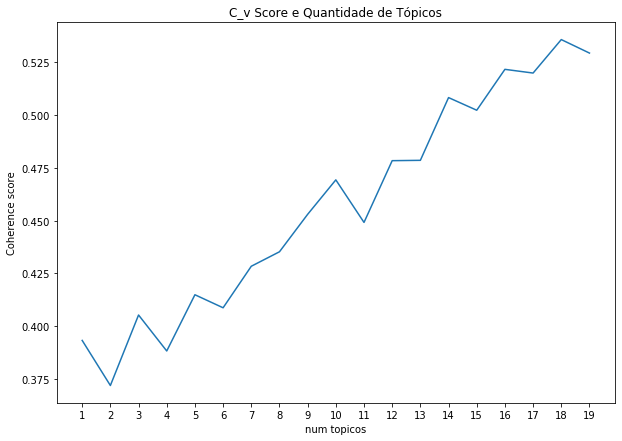

In [39]:
limit=20; start=1; step=1;

x = range(start, limit, step)

plt.plot(x, coherence_values)

plt.rcParams["figure.figsize"] = [10,7]

plt.xlabel("num topicos")
plt.ylabel("Coherence score")
plt.xticks(range(1, 20))
plt.title('C_v Score e Quantidade de Tópicos')
plt.show()

<p>Os resultados para esta aplicação indicam que o Coherence Score vai aumentando com a quantidade de tópicos. Entretanto, como o objeto analisado são comentários que, na maior parte, tem pouco conteúdo, duas análises podem ser feitas: </p>
       <ol>
           <li>Quantidade de Tópicos antes da primeira queda brusca ou suavização do crescimento do indicador - 3 Tópicos.</li>
           <li>Quantidade de Tópicos com maior valor do indicador - 18 Tópicos.</li>
       </ol>
 <p> O gráfico abaixo indica os 18 tópicos escolhidos e as palavras mais importantes por tópico. Interessante notar que os 18 tópicos acabam se aglutinando em 3 áreas razoávelmente bem delimitadas, indicando que a parcimônia de propor apenas 3 tópicos se mostrou correta, indicando que existem, de forma geral, 3 teores de conteúdo nos comentários.</p>

<h4>Análise de Tópicos</h4>

<h4>Cenário 2 - Análise com 18 Tópicos</h4>

In [37]:
second_best_model = model_list[17]
second_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(second_best_model)

# Visualize the topics
vis = pyLDAvis.gensim.prepare(second_model, vec_coment, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.007438 -0.089479       1        1  5.838332
1      0.302131  0.190264       2        1  5.759270
6      0.279196  0.181368       3        1  5.751412
9      0.272695  0.207139       4        1  5.725625
0     -0.264225  0.220061       5        1  5.629811
4     -0.074844 -0.019675       6        1  5.627593
15     0.033452 -0.062290       7        1  5.607466
5     -0.015512 -0.115323       8        1  5.606741
12     0.010813 -0.095175       9        1  5.605811
16    -0.024801 -0.094421      10        1  5.528880
13    -0.041919 -0.097102      11        1  5.493568
2     -0.283292  0.219869      12        1  5.484873
8     -0.264359  0.184918      13        1  5.458588
11    -0.017570 -0.157171      14        1  5.421291
17     0.073463 -0.060506      15        1  5.386540
3      0.042317 -0.108529      16        1  5.382813
10    -0.018398 -0.194172      17        1  5.378692
7     -0.001708 -0.109774      18        1  5.312693, topic_info=    Category        Freq       Term       Total  loglift  logprob
20   Default  425.000000        nao  425.000000  30.0000  30.0000
4    Default  388.000000        app  388.000000  29.0000  29.0000
58   Default  148.000000        bom  148.000000  28.0000  28.0000
37   Default  130.000000    entrega  130.000000  27.0000  27.0000
100  Default   91.000000     pedido   91.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
517  Topic18    4.935684   horrivel   20.398500   1.5161  -4.4188
136  Topic18    1.974274      unico    4.823255   2.0418  -5.3351
870  Topic18    1.974274       sair    4.858233   2.0346  -5.3351
71   Topic18    2.961410   problema   20.925062   0.9798  -4.9297
393  Topic18    1.974274  qualidade    5.894634   1.8412  -5.3351

[1233 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
474       9  0.964688      -se
1574      5  1.006646      [?]
1354      5  1.006646      aba
488      10  0.905398   abaixo
941       4  0.496145      abc
...     ...       ...      ...
226       4  0.119821      vou
226       7  0.718928      vou
226      16  0.119821      vou
1960     17  1.019889  whopper
2018      4  1.026041    zuado

[1371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 7, 10, 1, 5, 16, 6, 13, 17, 14, 3, 9, 12, 18, 4, 11, 8])

<p>No primeiro cluster <i>(tópicos na esquerda superior)</i>, as palavras mais relevantes são <b>"app, ótimo, excelente, restaurante, pedidos, servico, loja"</b> entre outras. Estas palavras podem indicar que um ponto forte do aplicativo, na percepção dos usuários, é a experiencia que o usuário tem com o aplicativo em relação à lista de lojas e restaurantes.</p>

<p>No segundo cluster <i>(tópicos inferiores)</i>, algumas palavras relevantes são <b>"bom, entrega, atende, recomento, rapido, entregador, gostei, tempo"</b> entre outras. Este tópico pode indicar a percepção positiva dos usuários em relação ao serviço de entrega dos estabelecimentos listados no aplicativo.</p>

<p>Por último, o terceiro cluster <i>(tópicos na direita superior)</i>, mostram as palavras <b>"nao, funciona, pedido, pessimo, area, tela, localizacao, bairros, cartao, credito, opcao, login, bugado"</b> entre outras. Estas palavras podem indicar um mal funcionamento da aplicação, em relação a usabilidade do aplicativo, opções de pagamento ou então área de atendimento.</p>
<br>
<p>Os resultados são interessantes, porém há de se considerar uma importante limitação. A aplicação de limpeza de stop-words e lematização não são tão eficazes em textos como comentários de internet pois há muita variação linguística e typo, gerando ruído na análise. 
<p>Outro fator importante é levar em consideraçao o tipo de objeto de análise. Em textos longos, uma limpeza de stop-words menos cuidadosa pode passar se maiores problemas, porém, em comentários, a limpeza de uma palavra como "não", que é considerada uma stop-word, pode distorcer completamente o resultado, como no caso desta análise, na qual a palavra "não" foi a mais relevante.<p>

<h3>Referências</h3>
<ul>
    <li>Röder, M., Both, A., Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In Proceedings of the eighth ACM international conference on Web search and data mining (pp. 399-408). ACM.</li>
    <li>Syed, S., Spruit, M. (2017, October). Full-text or abstract? Examining topic coherence scores using latent dirichlet allocation. In 2017 IEEE International conference on data science and advanced analytics (DSAA) (pp. 165-174). IEEE.</li>
    <li>Blei, D. M., Ng, A. Y., Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.</li>
    <li>Blei, D. M. (2012). Surveying a suite of algorithms that offer a solution to managing large document archives. Communication of the ACM, 55(4), 77-84.</li>